In [231]:
from keras import layers,models,callbacks
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


In [266]:
data=pd.read_csv('data/train.csv')
test=pd.read_csv('data/test.csv')
full=pd.concat([data,test])
full.shape

(1309, 12)

In [267]:
full.drop(columns=['Cabin','PassengerId','Ticket'],inplace=True)
full.head()

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0


In [268]:
full['Sex']=full['Sex'].apply(lambda x : 1 if x=='male' else 0)
full=full[False==full['Embarked'].isnull()]
full['Embarked']=full['Embarked'].apply(lambda x : 0 if x=='S' else 1 if x=='C' else 2)
full['Fare']=full['Fare'].fillna(np.mean(full['Fare'].dropna().values))

In [269]:
full['Has_Age'] = full['Age'].isnull().map(lambda x : 0 if x == True else 1)
# extracted title using name
full['Title'] = full.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
full.head()

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Has_Age,Title
0,22.0,0,7.2500,"Braund, Mr. Owen Harris",0,3,1,1,0.0,1,Mr
1,38.0,1,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,1,1.0,1,Mrs
2,26.0,0,7.9250,"Heikkinen, Miss. Laina",0,3,0,0,1.0,1,Miss
3,35.0,0,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,1,1.0,1,Mrs
4,35.0,0,8.0500,"Allen, Mr. William Henry",0,3,1,0,0.0,1,Mr


In [270]:
full['Title'] = full['Title'].replace(['Capt', 'Col', 'Countess', 'Don',
                                               'Dr', 'Dona', 'Jonkheer', 
                                                'Major','Rev','Sir'],'Unknown') 
full['Title'] = full['Title'].replace(['Mlle', 'Ms','Mme'],'Miss')
full['Title'] = full['Title'].replace(['Lady'],'Mrs')

In [271]:
full['Title'] = full['Title'].map({"Mr":0, "Unknown" : 1, "Master" : 2, "Miss" : 3, "Mrs" : 4 })
Pclass_title_pred = full.pivot_table(values='Age', index=['Pclass'], columns=['Title'],aggfunc=np.median).values
full['P_Ti_Age'] = full['Age']


In [272]:
# filling Missing age with Pclass & Title
for i in range(0,5):
    # 0,1,2,3,4
    for j in range(1,4):
        # 1,2,3
            full.loc[(full.Age.isnull()) & (full.Pclass == j) & (full.Title == i),'P_Ti_Age'] = Pclass_title_pred[j-1, i]
full['P_Ti_Age'] = full['P_Ti_Age'].astype('int')


In [273]:
age_ranges = np.array([16,100])
full['Age'] =age_ranges.searchsorted(full.Age)

full['P_Ti_Age'] = age_ranges.searchsorted(full.P_Ti_Age)


In [274]:
data_without_old_age=full.drop(columns=['Name','Has_Age','Age'])
data_without_old_age.head()

,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Title,P_Ti_Age
0,0,7.2500,0,3,1,1,0.0,0,1
1,1,71.2833,0,1,0,1,1.0,4,1
2,0,7.9250,0,3,0,0,1.0,3,1
3,0,53.1000,0,1,0,1,1.0,4,1
4,0,8.0500,0,3,1,0,0.0,0,1


In [275]:
data_without_old_age=pd.get_dummies(data_without_old_age,columns=['Pclass','P_Ti_Age','Parch','Embarked']) # one hot 
#Min-Max Scaler
column_to_normalize=['Fare']
data_without_old_age[column_to_normalize] = data_without_old_age[column_to_normalize].apply(lambda x: (x - x.min()) / (x.max() - x.min()))  


In [276]:
to_predict=data_without_old_age[data_without_old_age['Survived'].isnull()]
data=data_without_old_age[False==data_without_old_age['Survived'].isnull()]


In [277]:
data_without_old_age.head()

,Fare,Sex,SibSp,Survived,Title,Pclass_1,Pclass_2,Pclass_3,P_Ti_Age_0,P_Ti_Age_1,...,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9,Embarked_0,Embarked_1,Embarked_2
0,0.014151,1,1,0.0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
1,0.139136,0,1,1.0,4,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,0.015469,0,0,1.0,3,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
3,0.103644,0,1,1.0,4,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0.015713,1,0,0.0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0


In [297]:
model=models.Sequential()


In [316]:
model.add(layers.Dense(12,activation='relu',input_shape=(data_without_old_age.shape[1]-1,)))
model.add(layers.Dropout(p=0.2))
model.add(layers.Dense(6,activation='relu'))
model.add(layers.Dropout(p=0.2))
model.add(layers.Dense(1,activation='sigmoid'))


In [317]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

## doing cross validation to get the best out of it 

In [318]:
X=data.drop(columns=['Survived']).values
y=data['Survived'].values
accuracy=[]
loss=[]


In [319]:
sns.set()
sns.set(rc={'figure.figsize':(30,20)})


In [320]:
def smooth(points,factor=0.9): # fonction to smooth the output plot
    smoothed_points=[]
    for p in points:
        if(smoothed_points):
            prev=smoothed_points[-1]
            smoothed_points.append(prev*0.9+p*(1-factor))
        else:
            smoothed_points.append(p)
    return smoothed_points

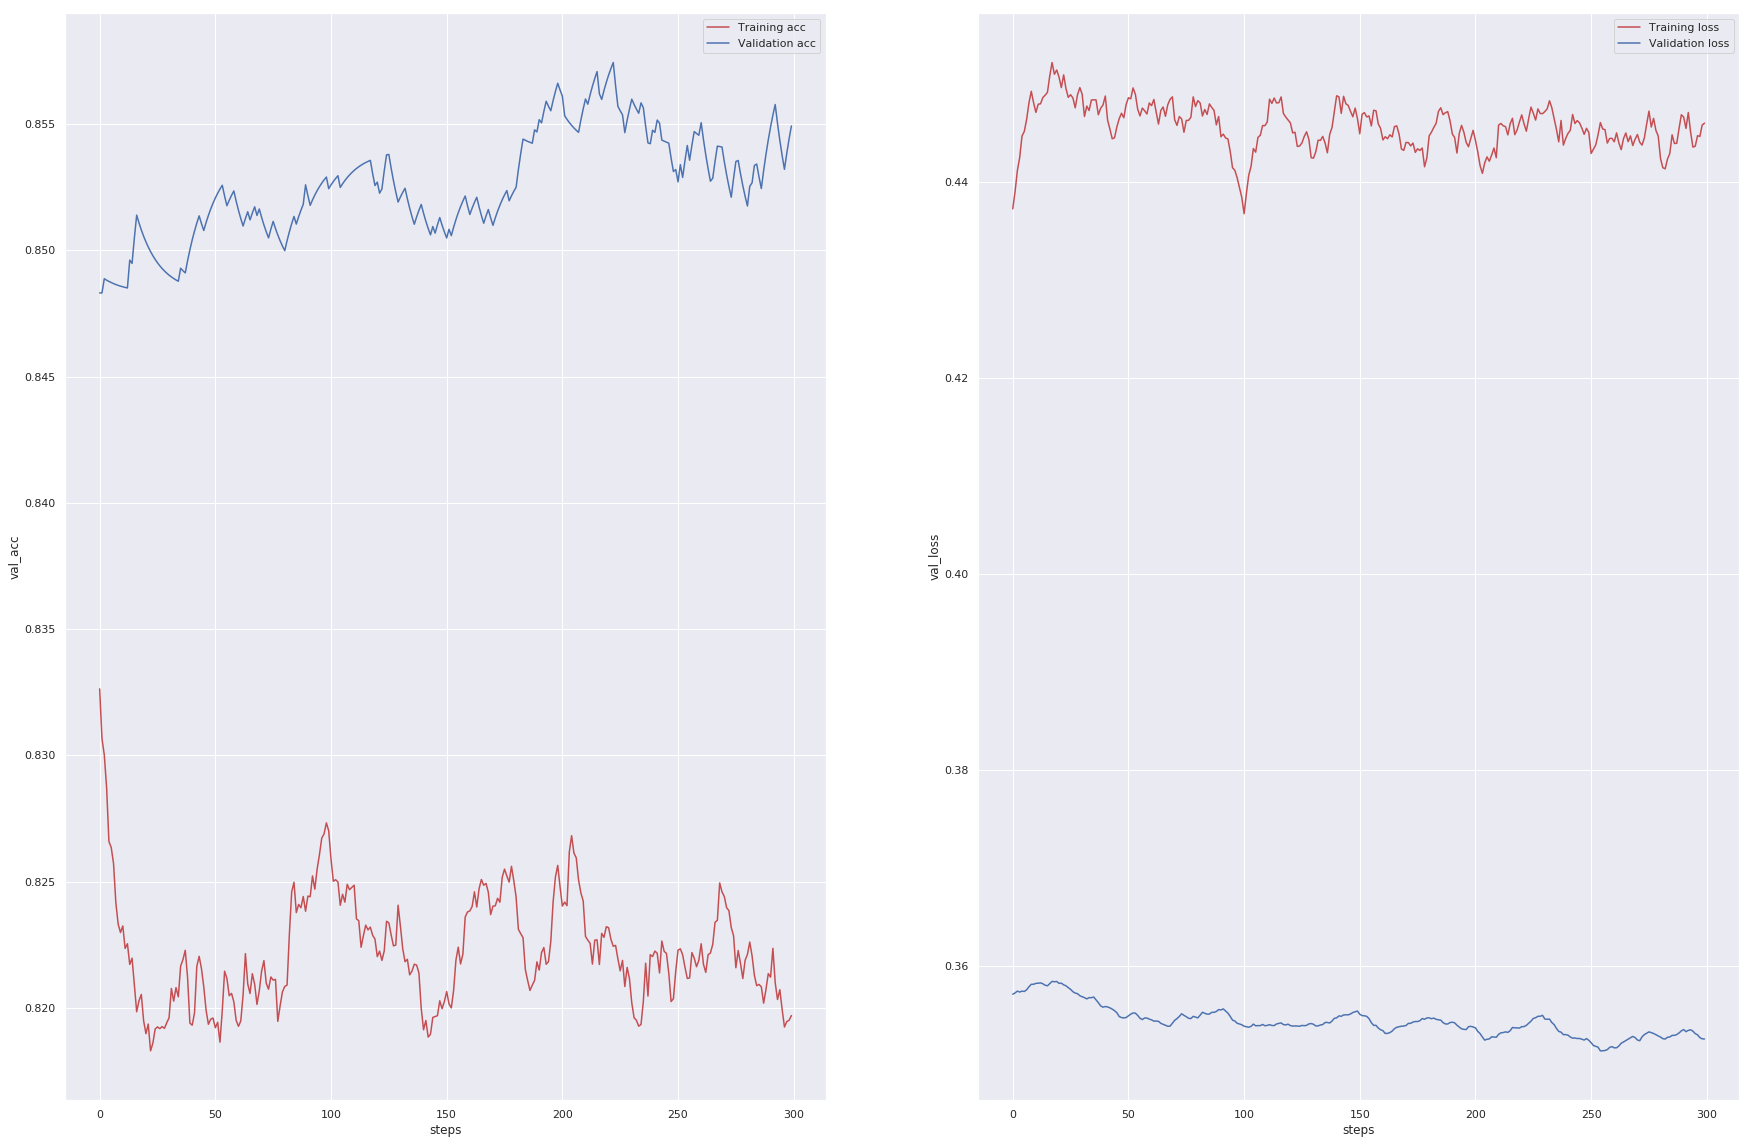

In [327]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=0)
f, axes = plt.subplots(1, 2)
cmp=0
nb_epochs=300
steps=[x for x in range(nb_epochs)]
for train_index, test_index in sss.split(X,y):
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y[train_index], y[test_index]
#stopper = callbacks.EarlyStopping(monitor='acc', patience=40)
history=model.fit(X_train,y_train,validation_data=[X_val,y_val],epochs=nb_epochs,batch_size=25,verbose=0)
tr_loss=smooth(history.history['loss'])
val_loss=smooth(history.history['val_loss'])
tr_acc=smooth(history.history['acc'])
val_acc = smooth(history.history['val_acc'])
d = {'tr_loss': tr_loss,'steps':steps[:len(tr_loss)],'val_loss':val_loss,'tr_acc':tr_acc,'val_acc':val_acc}
df = pd.DataFrame(data=d)
sns.lineplot(  y="tr_acc", x= "steps", data=df,  ax=axes[0],color='r',label="Training acc")
sns.lineplot(  y="val_acc", x= "steps", data=df,  ax=axes[0],color='b',label="Validation acc")
sns.lineplot(  y="tr_loss", x= "steps", data=df,  ax=axes[1],color='r',label="Training loss" )
sns.lineplot(  y="val_loss", x= "steps", data=df,  ax=axes[1],color='b',label="Validation loss" )

In [322]:
res_df=pd.DataFrame(columns=['PassengerId','Survived'],data=test['PassengerId'])

In [323]:
#history=model.fit(data.drop(columns=['Survived']).values,data['Survived'].values,epochs=nb_epochs,batch_size=128,verbose=0)
predictions=model.predict(to_predict.drop(columns =['Survived']).values)

In [324]:
res_df['Survived']=predictions
res_df['Survived']=res_df['Survived'].apply(lambda x: 1 if x>0.5 else 0)

In [325]:
res_df.tail()

,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,1


In [326]:
res_df.to_csv('output/keras_is_back.csv',header=True,index=False)

In [329]:
# dez ta5tef 
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(to_predict.drop(columns =['Survived']).values)
#random_forest.score(X_train, y_train)
res_df['Survived']=y_pred
res_df['Survived']=res_df['Survived'].apply(lambda x: 1 if x>0.5 else 0)
res_df.to_csv('output/RF_is_back.csv',header=True,index=False)